# INFO212 Assignment2 T22
*Name: Qinru Yang ID: 32022940961  
Name: Rongshen He ID: 320220940271  
Name: Qirui Zhang ID:  
Name: Wei Dou ID:*

In [1]:
# altair installation
!pip install seaborn

In [19]:
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from IPython.display import HTML

## Data Collection  
- We first call the **World Bank API** to query data on GDP, unemployment rate, inflation, and other metrics for five countries, spanning nearly 40 years. We use the API because most of the existing datasets available online are not in JSON format. Since JSON data is often used for efficient front-end and back-end transmission and contains some unnecessary parameters, we decided to use the API to obtain the dataset in JSON format.   
- We constructs a URL for each country and indicator, sends a request to the World Bank API, and processes the JSON response. The data for each indicator and country is stored in a dictionary.Finally, the combined data is saved into a JSON file named "world_bank_data.json". 

In [15]:
# 定义查询的国家和指标
countries = ["CN", "BR", "JP", "CA", "NP"]
indicators = {
    "GDP": "NY.GDP.MKTP.CD",
    "Unemployment": "SL.UEM.TOTL.ZS",
    "Inflation": "FP.CPI.TOTL",
    "Tariff rate": "TM.TAX.MANF.SM.AR.ZS",
    "GDP growth": "NY.GDP.MKTP.KD.ZG"
}
years = range(1980, 2019 + 1)
base_url = "http://api.worldbank.org/v2/country/{}/indicator/{}?date={}:{}&format=json&per_page=100"

# 获取数据并合并成一个JSON文件
data = {}
for indicator_name, indicator_code in indicators.items():
    data[indicator_name] = {}
    for country in countries:
        response = requests.get(base_url.format(country, indicator_code, years[0], years[-1]))
        if response.status_code == 200:
            result = response.json()
            if len(result) > 1:
                data[indicator_name][country] = result[1]
        else:
            print(f"Error fetching data for {country} - {indicator_name}: {response.status_code}")

# 保存数据到JSON文件
with open("world_bank_data.json", "w") as f:
    json.dump(data, f, indent=4)

print("Data has been saved to world_bank_data.json")


Data has been saved to world_bank_data.json


## Data Preparation  
- **Frist, we load the JSON files into Pandas DataFrames.** Because JSON data is nested and hierarchical and contains some unnecessary parameters, which can make it challenging to work with directly. 
- So we create **create_indicator_dataframe function**. It iterates through the JSON data for a specific indicator, extracting the country code, date, and corresponding indicator value for each entry. These records are then organized into a DataFrame with columns for country, date, and the specified indicator. 
- Then we create **display_dfs function**. It's used to beautify and display multiple dataframes in a single output. It utilizes the **highlight_null** parameter to highlight missing values. It employs **to_html** to print the dataframes as HTML, making the output easier to observe.

In [31]:
# 国家名称映射字典
country_names = {"CN": "China", "BR": "Brazil", "JP": "Japan", "CA": "Canada", "NP": "Nepal"}

def create_indicator_dataframe(data, indicator):
    records = [(country_names[country_code], int(entry['date']), entry['value']) for country_code, values in data[indicator].items() for entry in values]
    df = pd.DataFrame(records, columns=['country', 'date', indicator])
    df_pivot = df.pivot(index='date', columns='country', values=indicator)
    return df_pivot

# 创建GDP、Unemployment、Inflation的DataFrame
gdp_df = create_indicator_dataframe(data, "GDP")
unemployment_df = create_indicator_dataframe(data, "Unemployment")
inflation_df = create_indicator_dataframe(data, "Inflation")
tariff_df = create_indicator_dataframe(data, "Tariff rate")
gdp_growth_df = create_indicator_dataframe(data, "GDP growth")

dfs = dict(zip(["GDP DataFrame", "Unemployment DataFrame", "Inflation DataFrame", "Tariff rate DataFrame", "GDP growth DataFrame"]
               , [gdp_df, unemployment_df, inflation_df, tariff_df, gdp_growth_df]))
    
def display_dfs(df, title):
    df_list = {}
    for _df, _title in zip(df, title):
        df_list[_title] = _df.style.highlight_null(null_color='#B0E0E6').set_caption(_title)
    for _title, _styled_df in df_list.items():
        display(HTML(_styled_df.to_html()))


# 调用display_dfs函数来一次性输出所有DataFrame
display_dfs([gdp_df, unemployment_df, inflation_df, tariff_df, gdp_growth_df]
            , ["GDP DataFrame", "Unemployment DataFrame", "Inflation DataFrame", "Tariff rate DataFrame", "GDP growth DataFrame"])

country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,nan,274776566028.053009,306165314855.846008,1129377244854.040039,1945916583.333330
1981,nan,307246642755.859009,289576581830.448975,1245221410764.149902,2275583316.666670
1982,nan,314647807408.607971,283928672988.111023,1158731426905.850098,2395423680.228520
1983,nan,341866277182.732971,304748904221.289001,1270859919742.899902,2447174803.540510
1984,nan,356718400123.543030,313728547706.896973,1345824500836.760010,2581207387.797090
1985,nan,366186012449.651978,309835803013.586975,1427019759717.409912,2619913955.515560
1986,nan,379006836991.723999,300514204520.968994,2120083812109.909912,2850782092.693870
1987,nan,433134238310.708984,327089403146.072998,2580748422781.089844,2957255379.543150
1988,nan,509380027626.554016,407844670393.057983,3125724434400.790039,3487009748.356380


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,nan,nan,nan,nan,nan
1981,nan,nan,nan,nan,nan
1982,nan,nan,nan,nan,nan
1983,nan,nan,nan,nan,nan
1984,nan,nan,nan,nan,nan
1985,nan,nan,nan,nan,nan
1986,nan,nan,nan,nan,nan
1987,nan,nan,nan,nan,nan
1988,nan,nan,nan,nan,nan


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,0.000000,37.807670,nan,77.162600,8.998772
1981,0.000000,42.522896,nan,80.952953,10.001672
1982,0.000000,47.102175,nan,83.171906,11.171723
1983,0.000000,49.864053,nan,84.751939,12.554473
1984,0.000000,52.010590,nan,86.668701,12.911747
1985,0.000000,54.071265,nan,88.430049,13.951483
1986,0.000000,56.339439,26.048320,88.956727,16.602119
1987,0.000000,58.793646,27.932612,89.068970,18.386901
1988,0.000002,61.161992,33.187245,89.673354,20.038597


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,nan,nan,nan,nan,nan
1981,nan,nan,nan,nan,nan
1982,nan,nan,nan,nan,nan
1983,nan,nan,nan,nan,nan
1984,nan,nan,nan,nan,nan
1985,nan,nan,nan,nan,nan
1986,nan,nan,nan,nan,nan
1987,nan,nan,nan,nan,nan
1988,nan,nan,nan,3.960000,nan


country,Brazil,Canada,China,Japan,Nepal
date,,,,,
1980,9.200000,2.177199,7.834145,2.817591,-2.319394
1981,-4.250000,3.415065,5.112761,4.260624,8.341974
1982,0.830000,-3.166150,9.017114,3.279743,3.779375
1983,-2.930000,2.562254,10.770203,3.630199,-2.977406
1984,5.400000,5.898569,15.191540,4.410880,9.681130
1985,7.850000,4.737681,13.430678,5.159808,6.144905
1986,7.490000,2.121481,8.949962,3.294048,4.565651
1987,3.530000,4.072016,11.657428,4.648861,1.695618
1988,-0.060000,4.410839,11.222595,6.661637,7.696809


- We create **clear_Nan function** to clear the nan data in the dataframe

In [34]:
def clear_Nan(df,value=0):
    Nan_mask = df.isna()
    df[Nan_mask] = value
    return Nan_mask

gdp_df = clear_Nan(gdp_df, 0)
unemployment_df = clear_Nan(unemployment_df, 0)
inflation_df = clear_Nan(inflation_df, 0)
tariff_df = clear_Nan(tariff_df, 0)
gdp_growth_df = clear_Nan(gdp_growth_df, 0)

In [21]:
def create_country_dataframe(dfs, country):
    out_df = pd.DataFrame()
    indicators = dfs.keys()

    for df in dfs.values():
        out_df = pd.concat((out_df,df[country]),axis=1) 
    out_df.columns = indicators
    return out_df

## Data Analysis
- Perform exploratory data analysis (EDA) to understand the datasets. 
- Calculate summary statistics and identify trends over time for each 
indicator. 

In [129]:
dfs_summary = {}

for (name,df) in dfs.items():
    dfs_summary[name] = df.describe()
display_dfs(dfs_summary.values(), dfs_summary.keys())

country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,950475755554.892578,954144577189.869507,3534644162818.860352,4070476970661.221680,10071952382.136709
std,840043881263.569336,540811136966.942993,4405534148271.839844,1469988285577.757080,9437549106.365099
min,0.000000,274776566028.053009,283928672988.111023,1129377244854.040039,1945916583.333330
25%,403150971309.518005,576093169615.360840,411992751614.119263,3170859601098.084961,3515671811.831993
50%,662368828394.916992,708696994313.244995,1152671067253.620117,4558345699696.529297,5263947296.005489
75%,1720814683327.167480,1534243479110.984863,5348066279953.450195,5000017567691.787109,13641903206.675951
max,2616156223977.470215,1846597421834.979980,14279968506242.800781,6272362996105.030273,34186180695.996899


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,6.639525,5.682500,2.864750,2.771250,7.727600
std,4.475284,3.783724,1.907509,1.924971,4.819939
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.805000,6.985000,3.255000,3.260000,10.655000
75%,10.250000,7.790000,4.535000,4.382500,10.666250
max,12.790000,11.380000,4.720000,5.390000,10.682000


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,58.253041,81.457677,69.369470,97.541729,67.052250
std,54.751145,21.642812,39.709831,7.310468,52.658025
min,0.000000,37.807670,0.000000,77.162600,8.998772
25%,0.000677,66.512235,40.140815,93.828495,23.159284
50%,50.803137,80.806382,81.261160,100.681781,55.079209
75%,96.402236,98.690612,98.224998,102.253180,93.601846
max,167.397860,116.757298,125.083154,105.484268,188.729977


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,13.150750,3.071500,8.843750,2.098250,7.331000
std,9.427750,2.936415,10.350033,1.175759,7.428742
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.590000,0.000000,0.000000,2.030000,0.000000
50%,14.010000,2.920000,7.955000,2.395000,11.160000
75%,15.342500,4.415000,11.045000,2.787500,12.702500
max,44.420000,10.640000,40.750000,3.960000,23.230000


country,Brazil,Canada,China,Japan,Nepal
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,2.403548,2.396318,9.440715,1.870137,4.503492
std,3.330191,1.959001,2.735430,2.265391,2.640425
min,-4.350000,-3.166150,3.920251,-5.693236,-2.977406
25%,0.494951,1.793704,7.740025,0.579069,3.476499
50%,2.606843,2.647825,9.249783,1.617979,4.549365
75%,4.522135,3.261607,11.021114,3.351375,6.114706
max,9.200000,5.898569,15.191540,6.661637,9.681130


In [110]:
def create_country_dataframe(dfs, country):
    out_df = pd.DataFrame()
    indicators = dfs.keys()

    for df in dfs.values():
        out_df = pd.concat((out_df,df[country]),axis=1) 
    out_df.columns = indicators
    return out_df

country_dfs = {}
for country in country_names.values():
    country_dfs[country] = create_country_dataframe(dfs,country)
    
df_corrs = {}


for (name,df) in country_dfs.items():
    df_corr = df.corr()
    df_corrs[name] = df_corr
    df_corr = df.style.set_caption(name)
    display(HTML(df_corr.to_html()))

,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
1980,306165314855.846008,0.000000,0.000000,0.000000,7.834145
1981,289576581830.448975,0.000000,0.000000,0.000000,5.112761
1982,283928672988.111023,0.000000,0.000000,0.000000,9.017114
1983,304748904221.289001,0.000000,0.000000,0.000000,10.770203
1984,313728547706.896973,0.000000,0.000000,0.000000,15.191540
1985,309835803013.586975,0.000000,0.000000,0.000000,13.430678
1986,300514204520.968994,0.000000,26.048320,0.000000,8.949962
1987,327089403146.072998,0.000000,27.932612,0.000000,11.657428
1988,407844670393.057983,0.000000,33.187245,0.000000,11.222595
1989,456289122063.158997,0.000000,39.242469,0.000000,4.206334


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
1980,0.000000,0.000000,0.000000,0.000000,9.200000
1981,0.000000,0.000000,0.000000,0.000000,-4.250000
1982,0.000000,0.000000,0.000000,0.000000,0.830000
1983,0.000000,0.000000,0.000000,0.000000,-2.930000
1984,0.000000,0.000000,0.000000,0.000000,5.400000
1985,0.000000,0.000000,0.000000,0.000000,7.850000
1986,0.000000,0.000000,0.000000,0.000000,7.490000
1987,0.000000,0.000000,0.000000,0.000000,3.530000
1988,0.000000,0.000000,0.000002,0.000000,-0.060000
1989,425595310393.455017,0.000000,0.000029,44.420000,3.160000


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
1980,1129377244854.040039,0.000000,77.162600,0.000000,2.817591
1981,1245221410764.149902,0.000000,80.952953,0.000000,4.260624
1982,1158731426905.850098,0.000000,83.171906,0.000000,3.279743
1983,1270859919742.899902,0.000000,84.751939,0.000000,3.630199
1984,1345824500836.760010,0.000000,86.668701,0.000000,4.410880
1985,1427019759717.409912,0.000000,88.430049,0.000000,5.159808
1986,2120083812109.909912,0.000000,88.956727,0.000000,3.294048
1987,2580748422781.089844,0.000000,89.068970,0.000000,4.648861
1988,3125724434400.790039,0.000000,89.673354,3.960000,6.661637
1989,3109455047823.930176,0.000000,91.710992,3.760000,4.925785


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
1980,274776566028.053009,0.000000,37.807670,0.000000,2.177199
1981,307246642755.859009,0.000000,42.522896,0.000000,3.415065
1982,314647807408.607971,0.000000,47.102175,0.000000,-3.166150
1983,341866277182.732971,0.000000,49.864053,0.000000,2.562254
1984,356718400123.543030,0.000000,52.010590,0.000000,5.898569
1985,366186012449.651978,0.000000,54.071265,0.000000,4.737681
1986,379006836991.723999,0.000000,56.339439,0.000000,2.121481
1987,433134238310.708984,0.000000,58.793646,0.000000,4.072016
1988,509380027626.554016,0.000000,61.161992,0.000000,4.410839
1989,567211993243.243042,0.000000,64.210074,10.640000,2.337330


,GDP DataFrame,Unemployment DataFrame,Inflation DataFrame,Tariff rate DataFrame,GDP growth DataFrame
1980,1945916583.333330,0.000000,8.998772,0.000000,-2.319394
1981,2275583316.666670,0.000000,10.001672,0.000000,8.341974
1982,2395423680.228520,0.000000,11.171723,0.000000,3.779375
1983,2447174803.540510,0.000000,12.554473,0.000000,-2.977406
1984,2581207387.797090,0.000000,12.911747,0.000000,9.681130
1985,2619913955.515560,0.000000,13.951483,0.000000,6.144905
1986,2850782092.693870,0.000000,16.602119,0.000000,4.565651
1987,2957255379.543150,0.000000,18.386901,0.000000,1.695618
1988,3487009748.356380,0.000000,20.038597,0.000000,7.696809
1989,3525225832.990530,0.000000,21.811389,0.000000,4.329648


## Data Visualization 

- Create visualizations to represent the trends and patterns discovered 
during EDA. 
- Use line plots, bar charts, and scatter plots to compare different 
economic indicators across countries. 
- Employ Seaborn’s advanced features like facet grids or pair plots to 
visualize multi-dimensional data.

Explore treads of different indicators across countries

In [35]:
import altair as alt
import pandas as pd

def draw_line_chart(name, df):
    df = df.reset_index()
    long_df = pd.melt(df, id_vars=['date'], var_name='Country', value_name=f'{name}')
    chart = alt.Chart(long_df).mark_line(point={'size': 10}).encode(
        x='date:O',  # 'date:T' if the year is in datetime format
        y=f'{name}:Q',
        color='Country:N',
        tooltip=['Country', 'date', f'{name}']
    ).properties(
        title=f'{name} of Five Countries',
        width=350,  # 设置宽度为300
        height=300  # 设置高度为200
    ).interactive()
    return chart

charts = [draw_line_chart(name, df) for name, df in dfs.items()]

# 将图表组织成四个部分，每部分放置两张图，并设置滚动范围
grid = alt.vconcat(
    alt.hconcat(*charts[:2]),
    alt.hconcat(*charts[2:4])
).configure_axis(
    labelFontSize=6,  # 设置坐标轴标签字体大小为10
    titleFontSize=10  # 设置坐标轴标题字体大小为12
)


grid.display()

alt.VConcatChart(...)

Explore relations between indicators

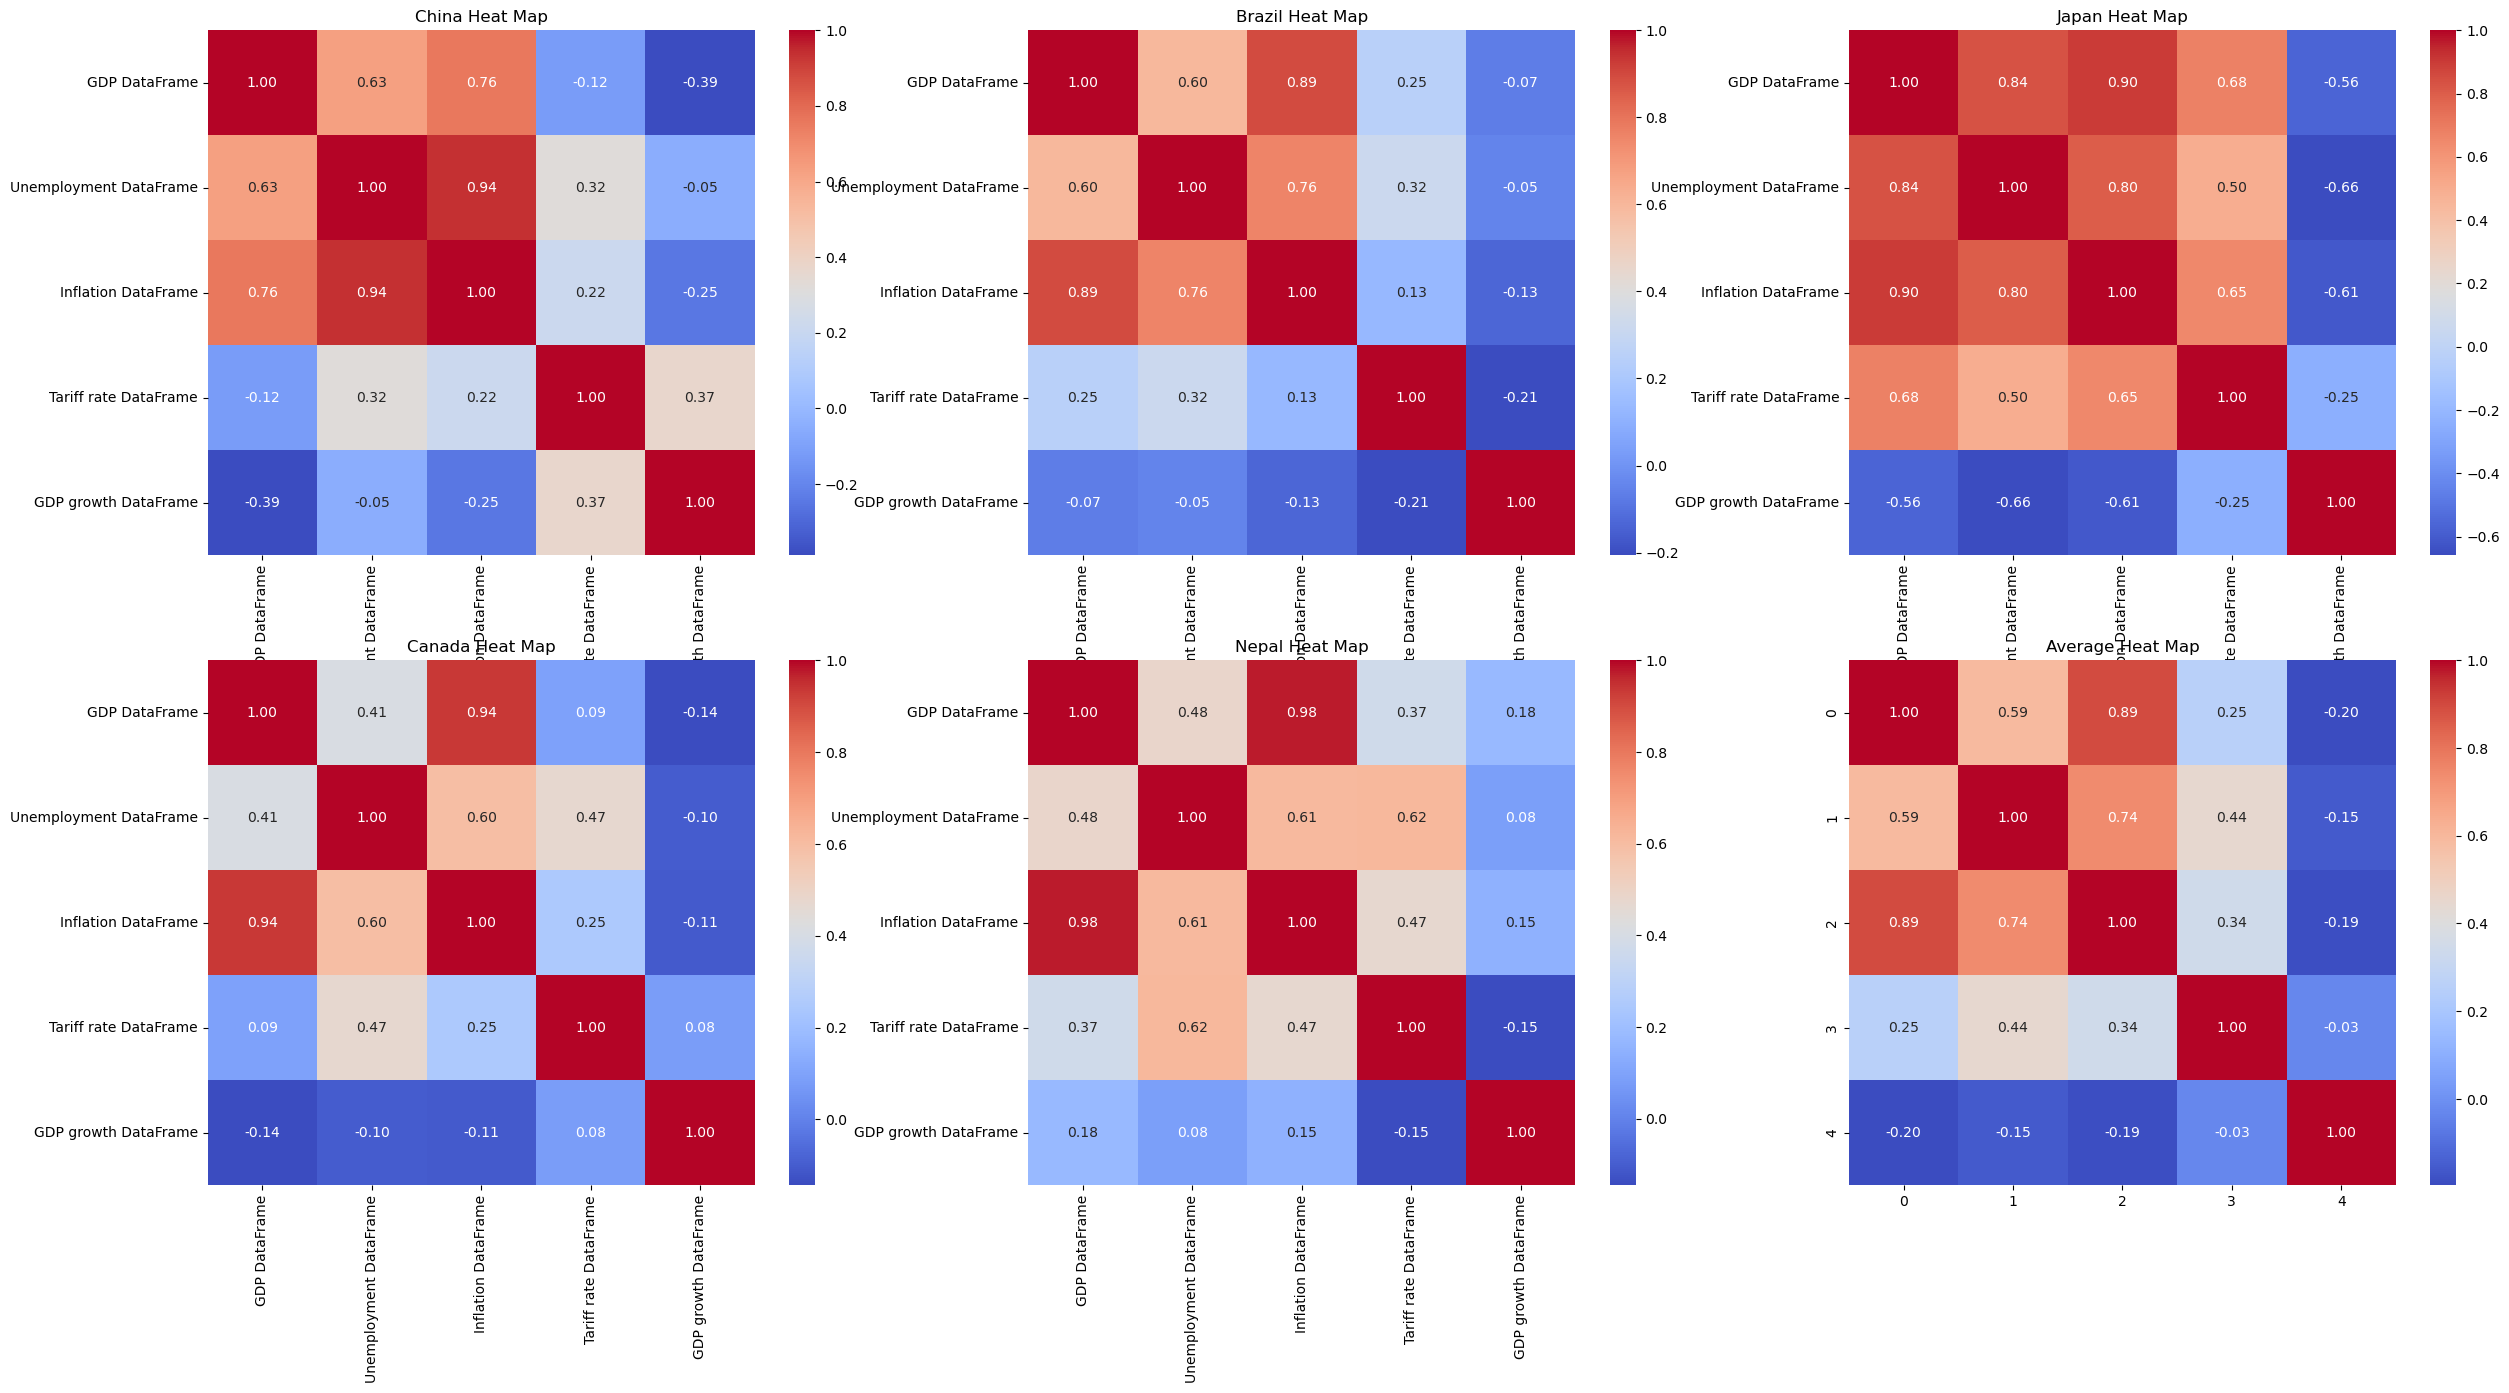

In [111]:
import seaborn as sns
fig, axs = plt.subplots(2, 3, figsize=(30, 15)) 

for (name, df_corr), ax in zip(df_corrs.items(), axs.flatten()):
    sns.heatmap(df_corr, ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
    ax.set_title(f'{name} Heat Map')

# mean_corr_matrix = pd.concat(df_corrs.values()).groupby(level=0).mean()
mean_corr_matrix = np.mean([df_corr.values for df_corr in df_corrs.values()], axis=0)
sns.heatmap(mean_corr_matrix, ax=axs[-1][-1], cmap='coolwarm', annot=True, fmt=".2f")
axs[-1][-1].set_title(f'Average Heat Map')



plt.show()

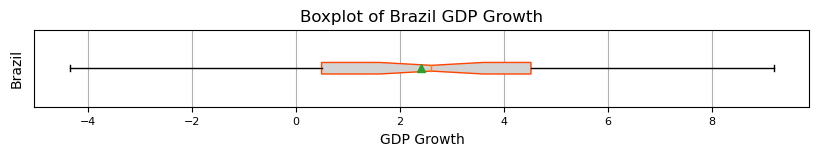

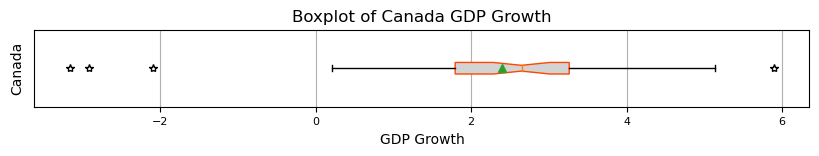

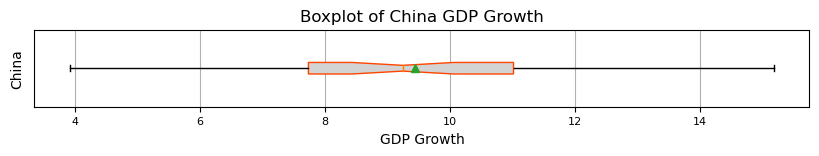

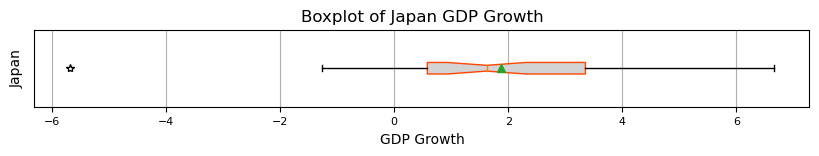

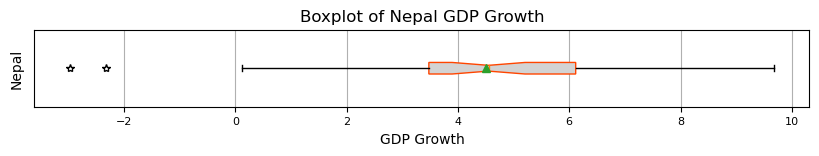

In [128]:
import matplotlib.pyplot as plt

# 循环遍历 gdp_growth_df 的每一列
for column in gdp_growth_df.columns:
    # 创建箱线图
    plt.figure(figsize=(10, 1))  # 设置图形大小
    plt.boxplot(gdp_growth_df[column], notch=True, sym='*', vert=False, showmeans=True, patch_artist=True,
                boxprops={'color': 'orangered', 'facecolor': 'lightgray'})  # 设置背景颜色更暗一些
    plt.xlabel('GDP Growth')  # 设置 x 轴标签
    plt.ylabel(column)  # 设置 y 轴标签为当前列名
    plt.title(f'Boxplot of {column} GDP Growth')
    plt.xticks(fontsize=8)
    plt.yticks(ticks=[], labels=[])
    plt.grid(axis='x')
    plt.show()

In [160]:
import pandas as pd
import altair as alt

# Generating Data
alt.Chart(gdp_df).transform_fold(
    list(country_names.keys()),  # 将字典视图转换为列表
    as_=['Date', 'GDP']
).mark_bar(
    opacity=0.3,
    binSpacing=0
).encode(
    alt.X('Date:Q', bin=True),
    alt.Y('GDP:Q', stack=None),
    alt.Color('Country:N')
)

alt.Chart(...)

In [152]:
import pandas as pd
import altair as alt
import numpy as np
np.random.seed(42)
# Generating Data
source = pd.DataFrame({
'Trial A': np.random.normal(0, 0.8, 1000),
'Trial B': np.random.normal(-2, 1, 1000),
'Trial C': np.random.normal(3, 2, 1000)
})
alt.Chart(source).transform_fold(
['Trial A', 'Trial B', 'Trial C'],
as_=['Experiment', 'Measurement']
).mark_bar(
opacity=0.3,
binSpacing=0
).encode(
alt.X('Measurement:Q').bin(maxbins=100),
alt.Y('count()').stack(None),
alt.Color('Experiment:N')
)


alt.Chart(...)